# **Seoul Bike Demand**

## Project Description

**Dataset:** https://archive.ics.uci.edu/dataset/560/seoul+bike+sharing+demand

**Project Structure**

The project follows this structure:
* Data Extraction
* Data Exploration
  * Exploratory Data Analysis
* Data Preparation
  * Feature Engineering
  * Pre-processing
* Model Training
* Model Evaluation

**Problem Statement:** How can we effectively predict bike rental demand by leveraging factors such as predicted weather, time of year, and time of day, to ensure an optimal balance of available bikes and meet customer demand?

## Data Extraction

In [ ]:
import math
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

from sklearn.preprocessing import StandardScaler, PolynomialFeatures
from sklearn.model_selection import StratifiedShuffleSplit, GridSearchCV, RandomizedSearchCV
from sklearn.linear_model import LinearRegression, Ridge, Lasso
from sklearn.svm import SVR
from sklearn.neighbors import KNeighborsRegressor
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor, AdaBoostRegressor
from xgboost import XGBRegressor
from sklearn.metrics import r2_score, mean_squared_error, mean_absolute_error

In [ ]:
data = pd.read_csv('/content/drive/MyDrive/Colab Notebooks/Machine Learning/Datasets/seoul_bike_data.csv', encoding='latin')

## Data Exploration

### Exploratory Data Analysis (EDA)

In [ ]:
print(f"Samples: {data.shape[0]}")
print(f"Features: {data.shape[1]}")

Samples: 8760
Features: 14


In [ ]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 8760 entries, 0 to 8759
Data columns (total 14 columns):
 #   Column                     Non-Null Count  Dtype  
---  ------                     --------------  -----  
 0   Date                       8760 non-null   object 
 1   Rented Bike Count          8760 non-null   int64  
 2   Hour                       8760 non-null   int64  
 3   Temperature(°C)            8760 non-null   float64
 4   Humidity(%)                8760 non-null   int64  
 5   Wind speed (m/s)           8760 non-null   float64
 6   Visibility (10m)           8760 non-null   int64  
 7   Dew point temperature(°C)  8760 non-null   float64
 8   Solar Radiation (MJ/m2)    8760 non-null   float64
 9   Rainfall(mm)               8760 non-null   float64
 10  Snowfall (cm)              8760 non-null   float64
 11  Seasons                    8760 non-null   object 
 12  Holiday                    8760 non-null   object 
 13  Functioning Day            8760 non-null   objec

**Insight:** The dataset has no missing values. There are 3 cateogrical features in the dataset.

In [ ]:
data.sample(3)

,Date,Rented Bike Count,Hour,Temperature(°C),Humidity(%),Wind speed (m/s),Visibility (10m),Dew point temperature(°C),Solar Radiation (MJ/m2),Rainfall(mm),Snowfall (cm),Seasons,Holiday,Functioning Day
6079,11/08/2018,425,7,26.7,67,0.8,2000,20.0,0.13,0.0,0.0,Summer,No Holiday,Yes
618,26/12/2017,481,18,-4.7,23,3.4,2000,-22.7,0.01,0.0,0.0,Winter,No Holiday,Yes
4592,10/06/2018,619,8,19.0,65,2.0,2000,12.2,0.28,0.0,0.0,Summer,No Holiday,Yes


In [ ]:
print(f"Duplicate rows: {data.duplicated().sum()}")

Duplicate rows: 0


In [ ]:
print(f"Unique seasons: {data['Seasons'].unique()}")

Unique seasons: ['Winter' 'Spring' 'Summer' 'Autumn']


In [ ]:
dates = pd.to_datetime(data['Date'], dayfirst=True)
print(f"Starting DateTime: {dates.min()}\nEnding DateTime: {dates.max()}")

Starting DateTime: 2017-12-01 00:00:00
Ending DateTime: 2018-11-30 00:00:00


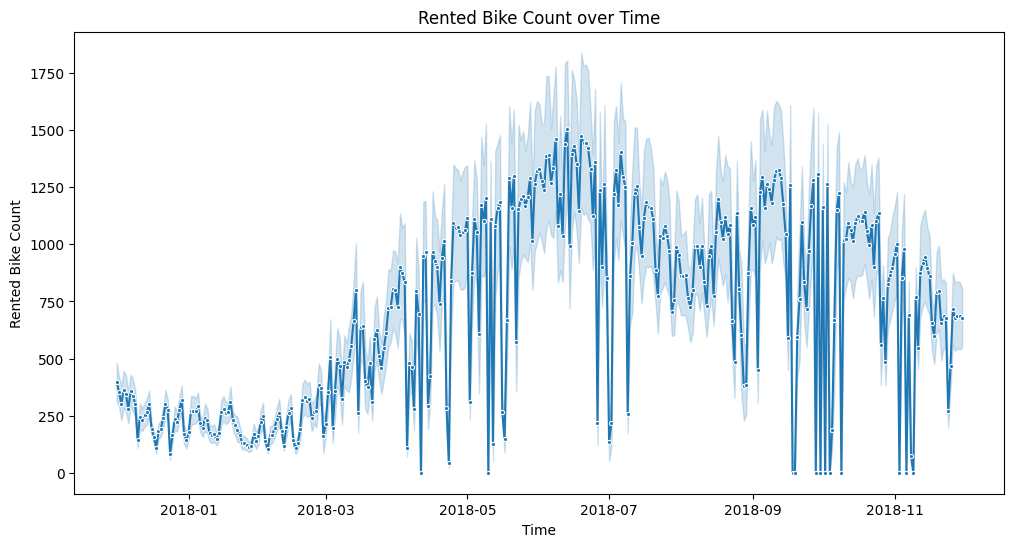

In [ ]:
plt.figure(figsize=(12, 6))
sns.lineplot(x=dates, y=data['Rented Bike Count'], marker='.')
plt.ylabel('Rented Bike Count')
plt.xlabel('Time')
plt.title('Rented Bike Count over Time')
plt.show()

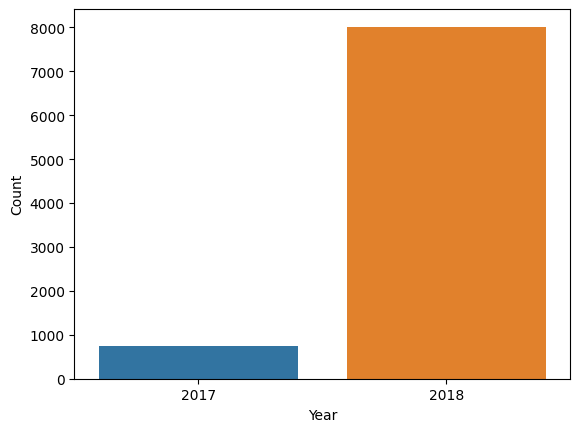

In [ ]:
sns.countplot(x=dates.dt.year)
plt.xlabel('Year')
plt.ylabel('Count')
plt.show()

In [ ]:
dates.dt.year.value_counts()

2018    8016
2017     744
Name: Date, dtype: int64

**Insight:** The data is biased. There are 744 values for 2017 compared to 8016 values for 2018.

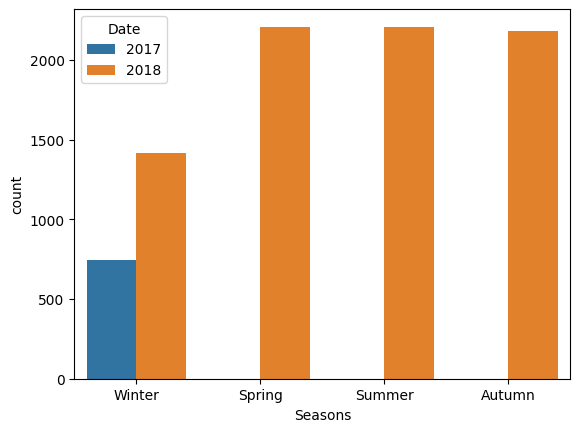

In [ ]:
sns.countplot(x=data['Seasons'], hue=dates.dt.year)
plt.show()

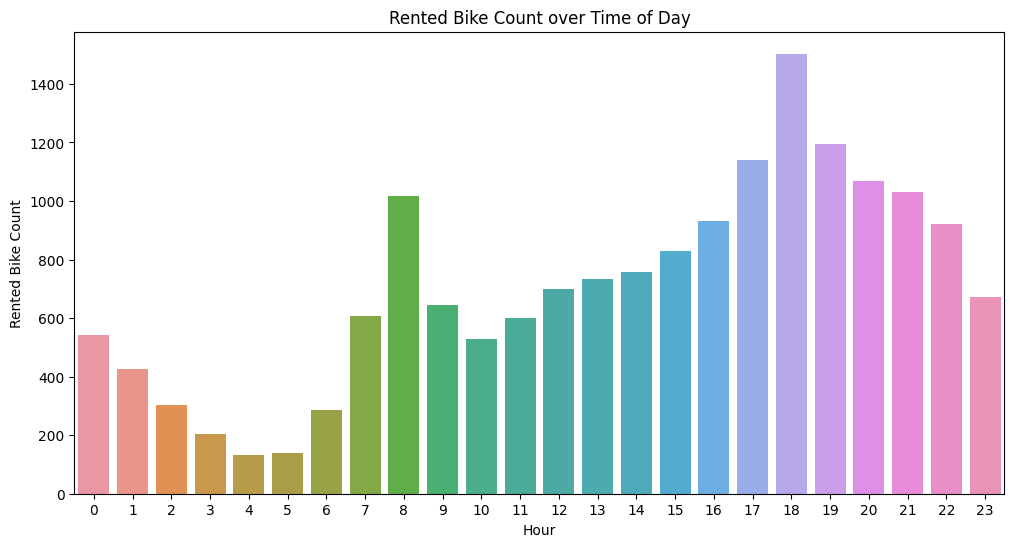

In [ ]:
plt.figure(figsize=(12, 6))
sns.barplot(data=data, x='Hour', y='Rented Bike Count', errorbar=None)
plt.xlabel('Hour')
plt.ylabel('Rented Bike Count')
plt.title('Rented Bike Count over Time of Day')
plt.show()

**Insight:** Peak times for renting are between *7:00-9:00* and *17:00-20:00*.

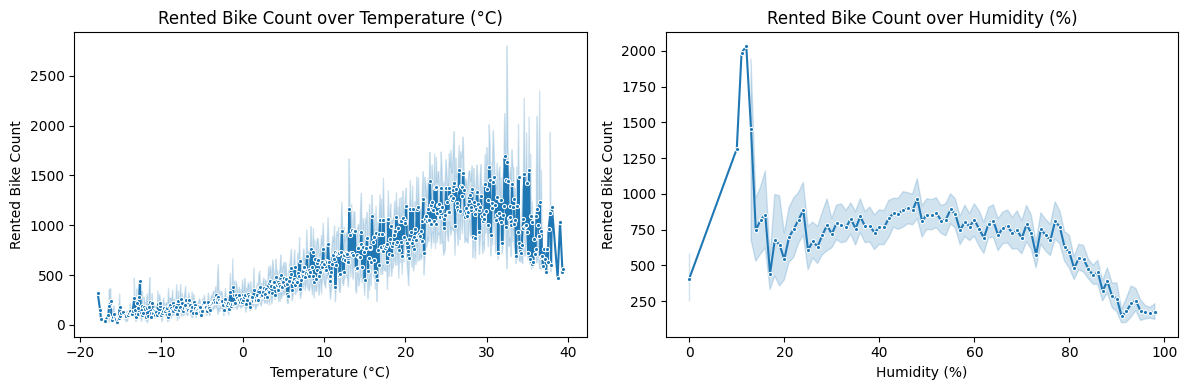

In [ ]:
plt.figure(figsize=(12, 4))

plt.subplot(1, 2, 1)
sns.lineplot(data=data, x='Temperature(°C)', y='Rented Bike Count', marker='.')
plt.xlabel('Temperature (°C)')
plt.ylabel('Rented Bike Count')
plt.title('Rented Bike Count over Temperature (°C)')

plt.subplot(1, 2, 2)
sns.lineplot(data=data, x='Humidity(%)', y='Rented Bike Count', marker='.')
plt.xlabel('Humidity (%)')
plt.ylabel('Rented Bike Count')
plt.title('Rented Bike Count over Humidity (%)')

plt.tight_layout()
plt.show()

**Insight:** The graphs above tell us that people don't rent bikes when:
* It is very cold
* It is very humid

Based on this, it is important to study the correlation/anticorrelation between bike rent count and the features related to different weather conditions.

In [ ]:
weather_cols = [
    'Temperature(°C)',
    'Humidity(%)',
    'Wind speed (m/s)',
    'Visibility (10m)',
    'Dew point temperature(°C)',
    'Solar Radiation (MJ/m2)',
]

In [ ]:
weather_data = data[weather_cols]

In [ ]:
weather_data.head(3)

,Temperature(°C),Humidity(%),Wind speed (m/s),Visibility (10m),Dew point temperature(°C),Solar Radiation (MJ/m2)
0,-5.2,37,2.2,2000,-17.6,0.0
1,-5.5,38,0.8,2000,-17.6,0.0
2,-6.0,39,1.0,2000,-17.7,0.0


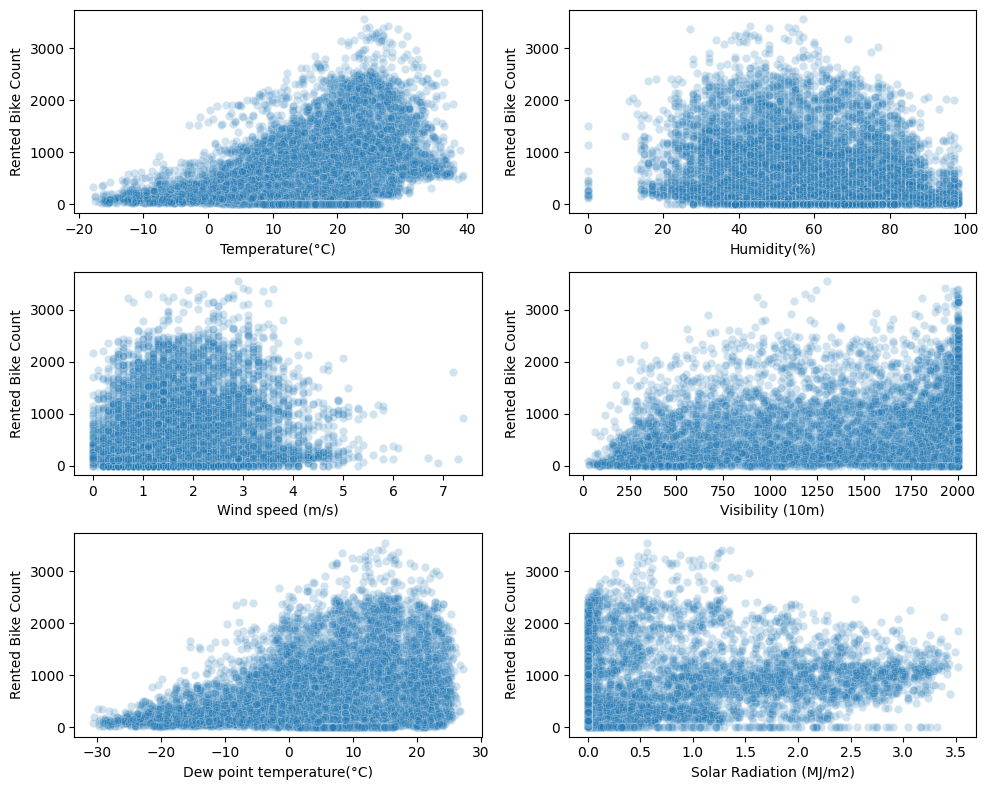

In [ ]:
plt.figure(figsize=(10, 8))

for i in range(6):
  plt.subplot(3, 2, i+1)
  sns.scatterplot(data=weather_data, x=weather_data.iloc[:, i], y=data['Rented Bike Count'], alpha=0.2)

plt.tight_layout()
plt.show()

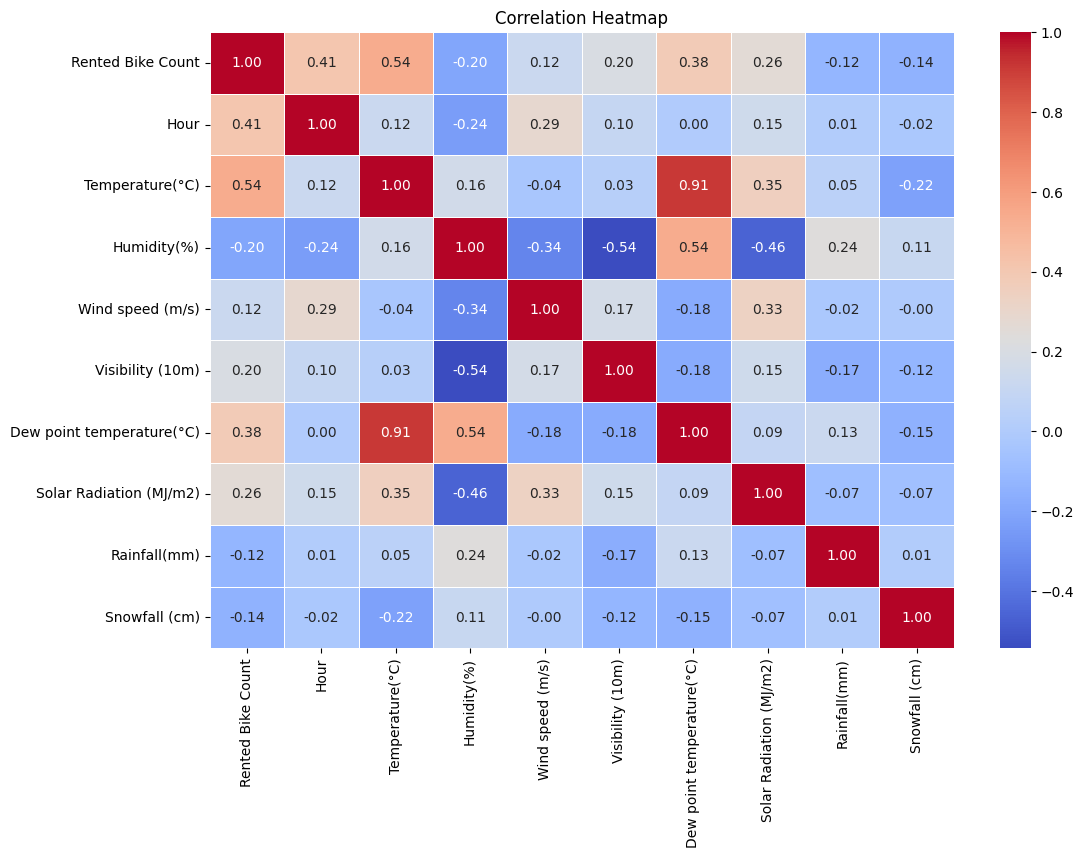

In [ ]:
plt.figure(figsize=(12, 8))
sns.heatmap(data.corr(numeric_only=True), annot=True, cmap='coolwarm', fmt=".2f", linewidths=.5)
plt.title('Correlation Heatmap')
plt.show()

**Insight**: Top 3 most correlated columns with our target feature are:
* `Temperature(°C)`
* `Dew point temperature(°C)`
* `Visibility (10m)`
* `Solar Radiation (MJ/m2)`

Similarly, anticorrelated features are:
* `Humidity (%)`
* `Snowfall (cm)`
* `Rainfall (mm)`

## Data Preparation

### Feature Engineering

In [ ]:
df = data.copy()
df.shape

(8760, 14)

In [ ]:
df['Date'] = pd.to_datetime(df['Date'], dayfirst=True)

In [ ]:
df['Day'] = df.Date.dt.day_name()
df['Month'] = df.Date.dt.month
df['Year'] = df.Date.dt.year

In [ ]:
df.sample(3)

,Date,Rented Bike Count,Hour,Temperature(°C),Humidity(%),Wind speed (m/s),Visibility (10m),Dew point temperature(°C),Solar Radiation (MJ/m2),Rainfall(mm),Snowfall (cm),Seasons,Holiday,Functioning Day,Day,Month,Year
2840,2018-03-29,1281,8,13.3,80,1.2,369,9.9,0.14,0.0,0.0,Spring,No Holiday,Yes,Thursday,3,2018
746,2018-01-01,178,2,-3.7,42,0.9,2000,-14.7,0.00,0.0,0.0,Winter,Holiday,Yes,Monday,1,2018
3845,2018-05-10,0,5,11.5,80,0.9,974,8.1,0.00,0.0,0.0,Spring,No Holiday,No,Thursday,5,2018


**Australian Apparent Temperature (APT):** APT is a type of heat index that can account for the impacts of temperature, humidity, wind-speed and radiation on the heat balance of the human body.

**Formula:** *Insert formula image here*

**Source:** https://www.vcalc.com/wiki/rklarsen/Australian+Apparent+Temperature+%28AT%29

We will use APT here because of Korea's close proximity with Australia.

In [ ]:
def calculate_vapor_pressure(humidity, temperature):
  return (humidity/100) * 6.105 * pow(math.exp(1), ((17.27*temperature)/(237.7+temperature)))

In [ ]:
def calculate_apparent_temperature(temperature, vapor_pressure, wind_speed):
  return temperature + 0.33*vapor_pressure - 0.70*wind_speed - 4.00

In [ ]:
temperature = df['Temperature(°C)'].values
humidity = df['Humidity(%)'].values
wind_speed = df['Wind speed (m/s)'].values

In [ ]:
vapor_pressure = calculate_vapor_pressure(humidity, temperature)

In [ ]:
apparent_temperature = calculate_apparent_temperature(temperature, vapor_pressure, wind_speed)

In [ ]:
df['APT'] = apparent_temperature

In [ ]:
df.sample(3)

,Date,Rented Bike Count,Hour,Temperature(°C),Humidity(%),Wind speed (m/s),Visibility (10m),Dew point temperature(°C),Solar Radiation (MJ/m2),Rainfall(mm),Snowfall (cm),Seasons,Holiday,Functioning Day,Day,Month,Year,APT
3190,2018-04-12,1142,22,13.5,15,2.2,2000,-12.6,0.00,0.0,0.0,Spring,No Holiday,Yes,Thursday,4,2018,8.724488
4554,2018-06-08,3309,18,26.2,54,2.2,1183,16.1,0.88,0.0,0.0,Summer,No Holiday,Yes,Friday,6,2018,26.702546
7315,2018-10-01,2122,19,16.2,62,2.2,2000,8.9,0.00,0.0,0.0,Autumn,No Holiday,Yes,Monday,10,2018,14.419613


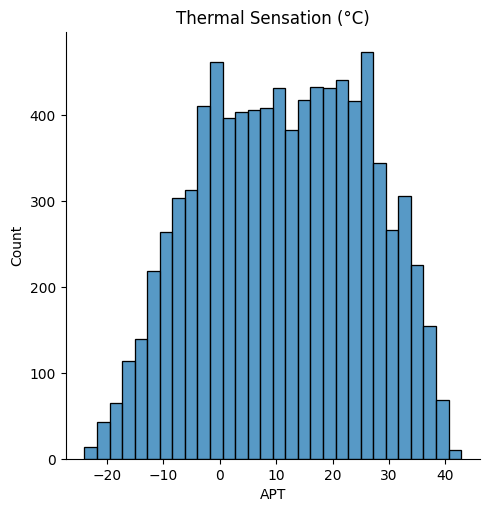

In [ ]:
sns.displot(data=df, x='APT', kind='hist')
plt.xlabel('APT')
plt.title('Thermal Sensation (°C)')
plt.show()

### Pre-processing

In [ ]:
df.dtypes

Date                         datetime64[ns]
Rented Bike Count                     int64
Hour                                  int64
Temperature(°C)                     float64
Humidity(%)                           int64
Wind speed (m/s)                    float64
Visibility (10m)                      int64
Dew point temperature(°C)           float64
Solar Radiation (MJ/m2)             float64
Rainfall(mm)                        float64
Snowfall (cm)                       float64
Seasons                              object
Holiday                              object
Functioning Day                      object
Day                                  object
Month                                 int64
Year                                  int64
APT                                 float64
dtype: object

In [ ]:
df['is_functioning_day'] = df['Functioning Day'].map({'Yes': 1, 'No': 0})

In [ ]:
df['is_holiday'] = df['Holiday'].map({'Holiday': 1, 'No Holiday': 0})

In [ ]:
df = pd.get_dummies(df, columns=['Seasons', 'Day'])

In [ ]:
df = df.drop(columns=['Date', 'Functioning Day', 'Holiday'])

In [ ]:
df.sample(3)

,Rented Bike Count,Hour,Temperature(°C),Humidity(%),Wind speed (m/s),Visibility (10m),Dew point temperature(°C),Solar Radiation (MJ/m2),Rainfall(mm),Snowfall (cm),...,Seasons_Spring,Seasons_Summer,Seasons_Winter,Day_Friday,Day_Monday,Day_Saturday,Day_Sunday,Day_Thursday,Day_Tuesday,Day_Wednesday
6174,346,6,28.4,74,1.0,1700,23.3,0.00,0.0,0.0,...,0,1,0,0,0,0,0,0,0,1
3899,18,11,12.0,96,1.0,184,11.3,0.14,3.5,0.0,...,1,0,0,0,0,1,0,0,0,0
7423,5,7,16.5,97,2.3,364,16.0,0.00,9.5,0.0,...,0,0,0,0,0,1,0,0,0,0


In [ ]:
df.shape

(8760, 26)

**Note:** Since the data is biased (more values for 2018), a Stratified Split should be used to make the class distribution is uniform across train and test sets.

In [ ]:
splitter = StratifiedShuffleSplit(n_splits=1, test_size=0.2, random_state=2)

In [ ]:
for train_index, test_index in splitter.split(df, df.Year):
  strat_train_set = df[df.index.isin(train_index)]
  strat_test_set = df[df.index.isin(test_index)]

In [ ]:
strat_train_set.shape, strat_test_set.shape

((7008, 26), (1752, 26))

In [ ]:
target = 'Rented Bike Count'

In [ ]:
X_train, X_test, y_train, y_test = strat_train_set.drop(target, axis=1), strat_test_set.drop(target, axis=1), strat_train_set[target], strat_test_set[target]


In [ ]:
X_train.shape, y_test.shape

((7008, 25), (1752,))

In [ ]:
scaler = StandardScaler()

In [ ]:
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

## Model Training

In [ ]:
lr = LinearRegression()
ridge = Ridge(alpha=0.01)
lasso = Lasso(alpha=0.01, max_iter=30000)
poly = PolynomialFeatures(degree=2)
poly_reg = LinearRegression()
knn = KNeighborsRegressor()
svm = SVR()
dtree = DecisionTreeRegressor()
rforest = RandomForestRegressor()
ada = AdaBoostRegressor()
xgb = XGBRegressor()

In [ ]:
lr.fit(X_train_scaled, y_train)

LinearRegression()

In [ ]:
ridge.fit(X_train_scaled, y_train)

Ridge(alpha=0.01)

In [ ]:
lasso.fit(X_train_scaled, y_train)

Lasso(alpha=0.01, max_iter=30000)

In [ ]:
X_train_poly = poly.fit_transform(X_train_scaled)
X_test_poly = poly.transform(X_test_scaled)
poly_reg.fit(X_train_poly, y_train)

LinearRegression()

In [ ]:
knn.fit(X_train_scaled, y_train)

KNeighborsRegressor()

In [ ]:
svm.fit(X_train_scaled, y_train)

SVR()

In [ ]:
dtree.fit(X_train_scaled, y_train)

DecisionTreeRegressor()

In [ ]:
rforest.fit(X_train_scaled, y_train)

RandomForestRegressor()

In [ ]:
ada.fit(X_train_scaled, y_train)

AdaBoostRegressor()

In [ ]:
xgb.fit(X_train_scaled, y_train)

XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=None, device=None, early_stopping_rounds=None,
             enable_categorical=False, eval_metric=None, feature_types=None,
             gamma=None, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=None, max_bin=None,
             max_cat_threshold=None, max_cat_to_onehot=None,
             max_delta_step=None, max_depth=None, max_leaves=None,
             min_child_weight=None, missing=nan, monotone_constraints=None,
             multi_strategy=None, n_estimators=None, n_jobs=None,
             num_parallel_tree=None, random_state=None, ...)

## Model Evaluation

In [ ]:
r2_test_linear = r2_score(y_test, lr.predict(X_test_scaled))
r2_train_linear = r2_score(y_train, lr.predict(X_train_scaled))

r2_test_ridge = r2_score(y_test, ridge.predict(X_test_scaled))
r2_train_ridge = r2_score(y_train, ridge.predict(X_train_scaled))

r2_test_lasso = r2_score(y_test, lasso.predict(X_test_scaled))
r2_train_lasso = r2_score(y_train, lasso.predict(X_train_scaled))

r2_test_poly = r2_score(y_test, poly_reg.predict(X_test_poly))
r2_train_poly = r2_score(y_train, poly_reg.predict(X_train_poly))

r2_test_knn = r2_score(y_test, knn.predict(X_test_scaled))
r2_train_knn = r2_score(y_train, knn.predict(X_train_scaled))

r2_test_svm = r2_score(y_test, svm.predict(X_test_scaled))
r2_train_svm = r2_score(y_train, svm.predict(X_train_scaled))

r2_test_dtree = r2_score(y_test, dtree.predict(X_test_scaled))
r2_train_dtree = r2_score(y_train, dtree.predict(X_train_scaled))

r2_test_rforest = r2_score(y_test, rforest.predict(X_test_scaled))
r2_train_rforest = r2_score(y_train, rforest.predict(X_train_scaled))

r2_test_ada = r2_score(y_test, ada.predict(X_test_scaled))
r2_train_ada = r2_score(y_train, ada.predict(X_train_scaled))

r2_test_xgb = r2_score(y_test, xgb.predict(X_test_scaled))
r2_train_xgb = r2_score(y_train, xgb.predict(X_train_scaled))

In [ ]:
scores = pd.DataFrame({
    'algorithm':['Linear', 'Ridge', 'Lasso', 'Poly', 'KNN', 'SVM', 'DTree', 'RForest', 'ADA', 'XGB'],
    'r2_test':[r2_test_linear, r2_test_ridge, r2_test_lasso, r2_test_poly, r2_test_knn, r2_test_svm, r2_test_dtree, r2_test_rforest, r2_test_ada, r2_test_xgb],
    'r2_train':[r2_train_linear, r2_train_ridge, r2_train_lasso, r2_train_poly, r2_train_knn, r2_train_svm, r2_train_dtree, r2_train_rforest, r2_train_ada, r2_train_xgb]
})

In [ ]:
scores = scores.sort_values(by='r2_test', ascending=False)

In [ ]:
scores

,algorithm,r2_test,r2_train
9,XGB,0.948070,0.988845
7,RForest,0.929313,0.989610
6,DTree,0.817710,1.000000
4,KNN,0.752460,0.853438
3,Poly,0.746501,0.762916
8,ADA,0.619080,0.617039
0,Linear,0.570945,0.572288
1,Ridge,0.570940,0.572288
2,Lasso,0.570914,0.572287
5,SVM,0.223598,0.253172


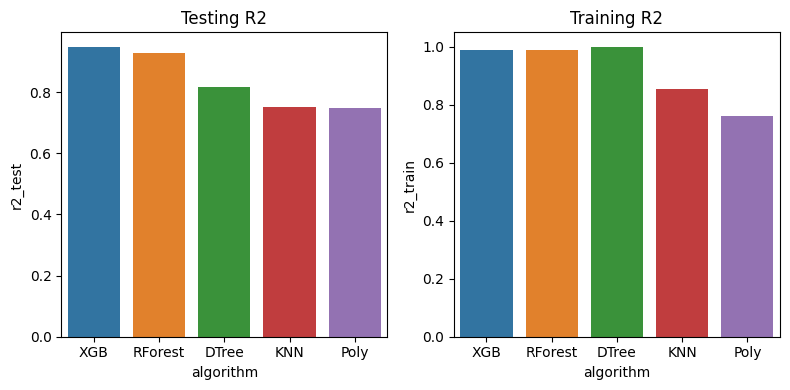

In [ ]:
top_5_scores = scores.head(5)

plt.figure(figsize=(8, 4))

plt.subplot(1, 2, 1)
sns.barplot(data=top_5_scores, x='algorithm', y='r2_test')
plt.title('Testing R2')

plt.subplot(1, 2, 2)
sns.barplot(data=top_5_scores, x='algorithm', y='r2_train')
plt.title('Training R2')

plt.tight_layout()
plt.show()

**Insight:** XGBoost outperforms all other models although Random Forest is pretty close too. It should also be noticed that we are seeing some cases of overfitting which can be reduced using some hyperparameter tuning.